In [1]:
# Import Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import statistics
import fastcluster
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
from itertools import permutations
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors

In [2]:
glass = pd.read_csv('glass.txt', sep=",")
glass.reset_index(drop=True, inplace=True)
glass_columns = glass.columns

categorical_features = ['ID', 'Glass_type']
numerical_features = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
cat_data = glass[categorical_features]
num_data = glass[numerical_features]
glass_class = pd.concat([glass['Glass_type'], num_data], axis=1)

scaler = MinMaxScaler(feature_range=(-1, 1))
x = pd.DataFrame(scaler.fit_transform(glass[numerical_features]))
x.columns = numerical_features
x_comb = pd.concat([cat_data, x], axis=1)

print(f'\n----> SCALED DATASET : \n\n{x_comb}')
s_row, s_col = x.shape

print(f'\n*\tSamples : {s_row}, Dimensions : {len(glass.columns)}')


----> SCALED DATASET : 

      ID  Glass_type        RI        Na        Mg        Al        Si  \
0      1           1 -0.134328 -0.124812  1.000000 -0.495327 -0.296429   
1      2           1 -0.432836 -0.049624  0.603563 -0.333333  0.042857   
2      3           1 -0.558385 -0.157895  0.581292 -0.221184  0.135714   
3      4           1 -0.428446 -0.254135  0.643653 -0.376947  0.000000   
4      5           1 -0.449517 -0.236090  0.612472 -0.408100  0.167857   
..   ...         ...       ...       ...       ...       ...       ...   
209  210           7 -0.553995  0.025564 -1.000000  0.613707  0.000000   
210  211           7 -0.499561  0.260150 -1.000000  0.059190  0.160714   
211  212           7 -0.165935  0.091729 -1.000000  0.077882  0.289286   
212  213           7 -0.529412  0.097744 -1.000000  0.028037  0.357143   
213  214           7 -0.476734  0.052632 -1.000000  0.115265  0.267857   

            K        Ca        Ba   Fe  
0   -0.980676 -0.382900 -1.000000 -1.0  
1  

In [3]:
## ----------- MEDIAN ABSOLUTE DEVIATION (MAD) correlation matrix ---------------

def compute_median_absolute_deviation(df):
    return df.apply(lambda col: np.absolute(col - col.median()))

def generate_corr_elems(columns):
    comb = permutations(columns, 2)
    perms = list(comb)
    diag = [(col, col) for col in columns]
    return diag + perms

def compute_corr_matrix_values(df, corr_elems):
    corr_values = []
    for elem in corr_elems:
        corr_values.append(df[elem[0]].append(df[elem[1]], ignore_index=True).median(axis=0))
    return corr_values

def construct_corr_matrix(corr_values, num_columns):
    matrix = np.diag(corr_values[:num_columns])
    k = 0
    for i in range(num_columns):
        for j in range(num_columns):
            if i != j:
                matrix[i, j] = corr_values[num_columns:][k]
                k += 1
    return matrix

# Compute the Median Absolute Deviation
x_MAD = compute_median_absolute_deviation(x)
print(f'\n ---> Median Absolute Deviation : \n\n{x_MAD}')

# Generate the correlation matrix elements
corr_elems = generate_corr_elems(x_MAD.columns)
print(f'\n ---> The elements of the corr matrix are : \n\n{corr_elems}')

# Compute the correlation matrix values
corr_values = compute_corr_matrix_values(x_MAD, corr_elems)
print(f'\n ---> The values of the corr_elems are : \n')
for i, value in zip(corr_elems, corr_values):
    print(f'*The median of the columns ({i[0]},{i[1]}) -> {value}')

# Construct the correlation matrix
corr_matrix = construct_corr_matrix(corr_values, x_MAD.shape[1])
print(f'\n ---> Correlation matrix : \n\n{corr_matrix}')


 ---> Median Absolute Deviation : 

           RI        Na        Mg        Al        Si         K        Ca  \
0    0.292362  0.102256  0.449889  0.161994  0.360714  0.159420  0.027881   
1    0.006146  0.177444  0.053452  0.000000  0.021429  0.024155  0.143123   
2    0.131694  0.069173  0.031180  0.112150  0.071429  0.053140  0.152416   
3    0.001756  0.027068  0.093541  0.043614  0.064286  0.004831  0.070632   
4    0.022827  0.009023  0.062361  0.074766  0.103571  0.001610  0.098513   
..        ...       ...       ...       ...       ...       ...       ...   
209  0.127305  0.252632  1.550111  0.947040  0.064286  0.152979  0.107807   
210  0.072871  0.487218  1.550111  0.392523  0.096429  0.178744  0.037175   
211  0.260755  0.318797  1.550111  0.411215  0.225000  0.178744  0.029740   
212  0.102722  0.324812  1.550111  0.361371  0.292857  0.178744  0.022305   
213  0.050044  0.279699  1.550111  0.448598  0.203571  0.178744  0.003717   

           Ba   Fe  
0    0.000000  0.

In [4]:
# Eigen Value & Eigen Vector Decomposition

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

# Sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Print the sorted eigenvalues and eigenvectors
print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)

eig_vals_total = sum(eigenvalues)
explained_variance = [(i / eig_vals_total)*100 for i in eigenvalues]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)
print('\nExplained variance             : {}'.format(explained_variance))

print('Cumulative explained variance  : {}'.format(cum_explained_variance))

Eigenvalues:
[ 0.79038342  0.01404728  0.0087258   0.00570087  0.00174208 -0.00098342
 -0.00464348 -0.0112373  -0.08243992]

Eigenvectors:
[[-0.37767942  0.02801342  0.28058254  0.33286598  0.48381651  0.14336643
  -0.49991306  0.39590871  0.07588189]
 [-0.41652735  0.33415646  0.19437314  0.24296741 -0.26199309 -0.11661294
   0.60572312  0.31322254  0.26604987]
 [-0.34826821 -0.040782    0.38280599  0.09297035 -0.25376497 -0.57272866
  -0.27239539 -0.46948317 -0.18663787]
 [-0.42005231 -0.21862555 -0.45433256  0.2351888  -0.34767058  0.37813609
  -0.19886566 -0.29201947  0.35403731]
 [-0.41370479  0.32138685 -0.25926603 -0.73499429  0.20121174 -0.16910746
  -0.11855498  0.01420708  0.18650129]
 [-0.25408828 -0.30069099 -0.5653455   0.20979549  0.19988929 -0.37901808
   0.18895816  0.22305306 -0.46078857]
 [-0.31491558 -0.56228122  0.3523201  -0.27005388  0.2871788   0.29668736
   0.40958832 -0.21134412 -0.06845052]
 [-0.10094151 -0.2620085   0.13884329 -0.32603381 -0.59050634  0.13533


New projection:
            0         1         2         3         4   ID  Glass_type
0    0.758471  0.189466  0.920536  0.290547  0.130990    1           1
1    0.789032  0.351501  0.401352  0.035880  0.057347    2           1
2    0.814071  0.331979  0.274639 -0.079732  0.001853    3           1
3    0.864454  0.227936  0.418258 -0.000875  0.136030    4           1
4    0.829814  0.313019  0.368370 -0.130926  0.164332    5           1
..        ...       ...       ...       ...       ...  ...         ...
209  0.867643 -0.060885 -0.396361 -0.195250 -0.303032  210           7
210  0.934047  0.193011 -0.115015 -0.444640 -0.358525  211           7
211  0.811607  0.170814 -0.088941 -0.476969 -0.150226  212           7
212  0.941389  0.202812 -0.188255 -0.645611 -0.268295  213           7
213  0.925978  0.110180 -0.180742 -0.580626 -0.309301  214           7

[214 rows x 7 columns]


[]

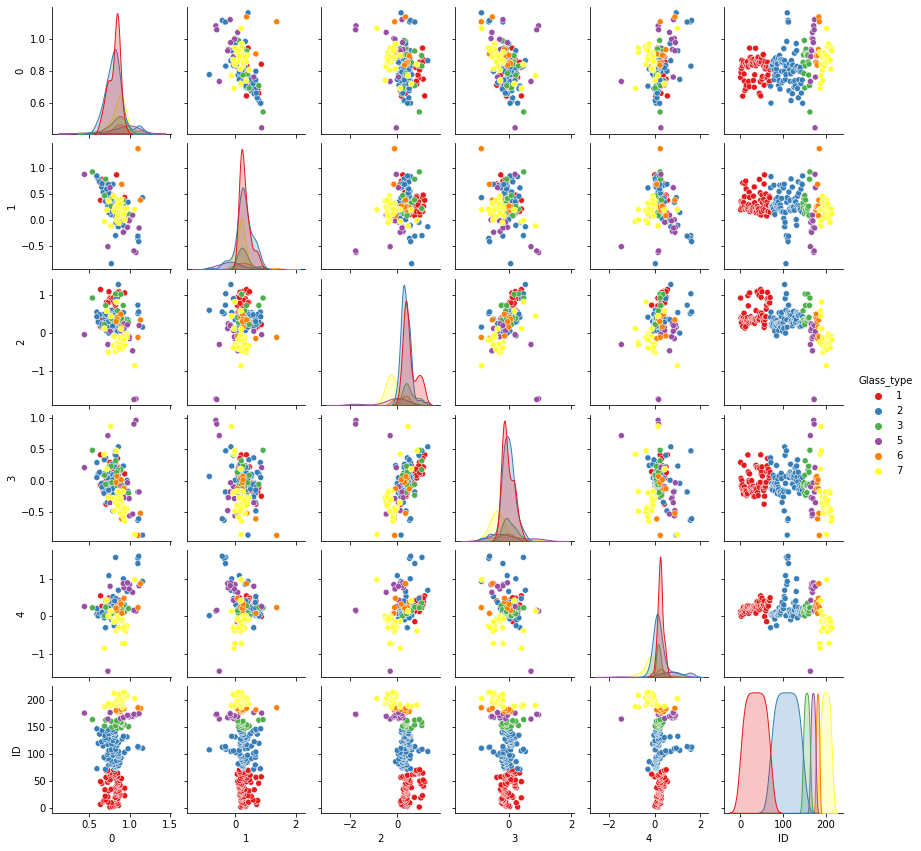

In [5]:
# Data Transformation.

# Select 'k' no of eigen vectors
k = 5
W = eigenvectors[:, :k] # Projection matrix

# Transform the original dataset
X_proj = x.dot(W)
X_proj_fin = pd.concat([X_proj, cat_data], axis=1)
X_proj_fin.to_csv('columns_heatmap.csv', index=False)
print('\nNew projection:')
print(X_proj_fin)
#X_proj_pd = pd.DataFrame(X_proj)
#print(X_proj)

sns.pairplot(data=X_proj_fin, hue='Glass_type', height=2, palette="Set1")
plt.plot()

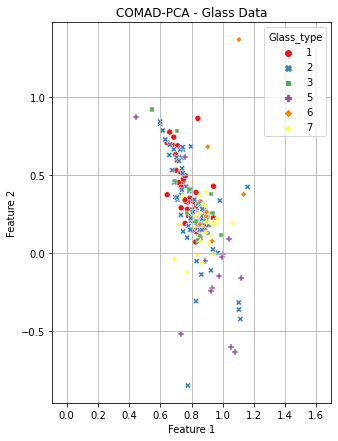

In [15]:
# Calculate the end points of the PC axes (scaled by the square root of the absolute eigenvalues)
pc_endpoints = eigenvectors * np.sqrt(np.abs(eigenvalues))
  
def Original():
    
    # Set the figure size
    plt.figure(figsize=(5, 7))

    df = pd.DataFrame(X_proj_fin)

    # Plot the DataFrame using Seaborn's scatterplot function
    sns.scatterplot(x=X_proj_fin[0], y=X_proj_fin[1],hue = X_proj_fin['Glass_type'], style=X_proj_fin['Glass_type'], data=df, palette="Set1" )

    # Show the plot
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('COMAD-PCA - Glass Data')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    

Original()
#Transformed()

In [7]:
X_proj_1D = X_proj.to_numpy()
#X_proj_1D = X_proj.flatten()[::-1]

# Calculate the condensed distance matrix
condensed_dist_matrix = pdist(X_proj_1D)

# Convert the condensed distance matrix to a square distance matrix
dist_matrix = pd.DataFrame(squareform(condensed_dist_matrix))

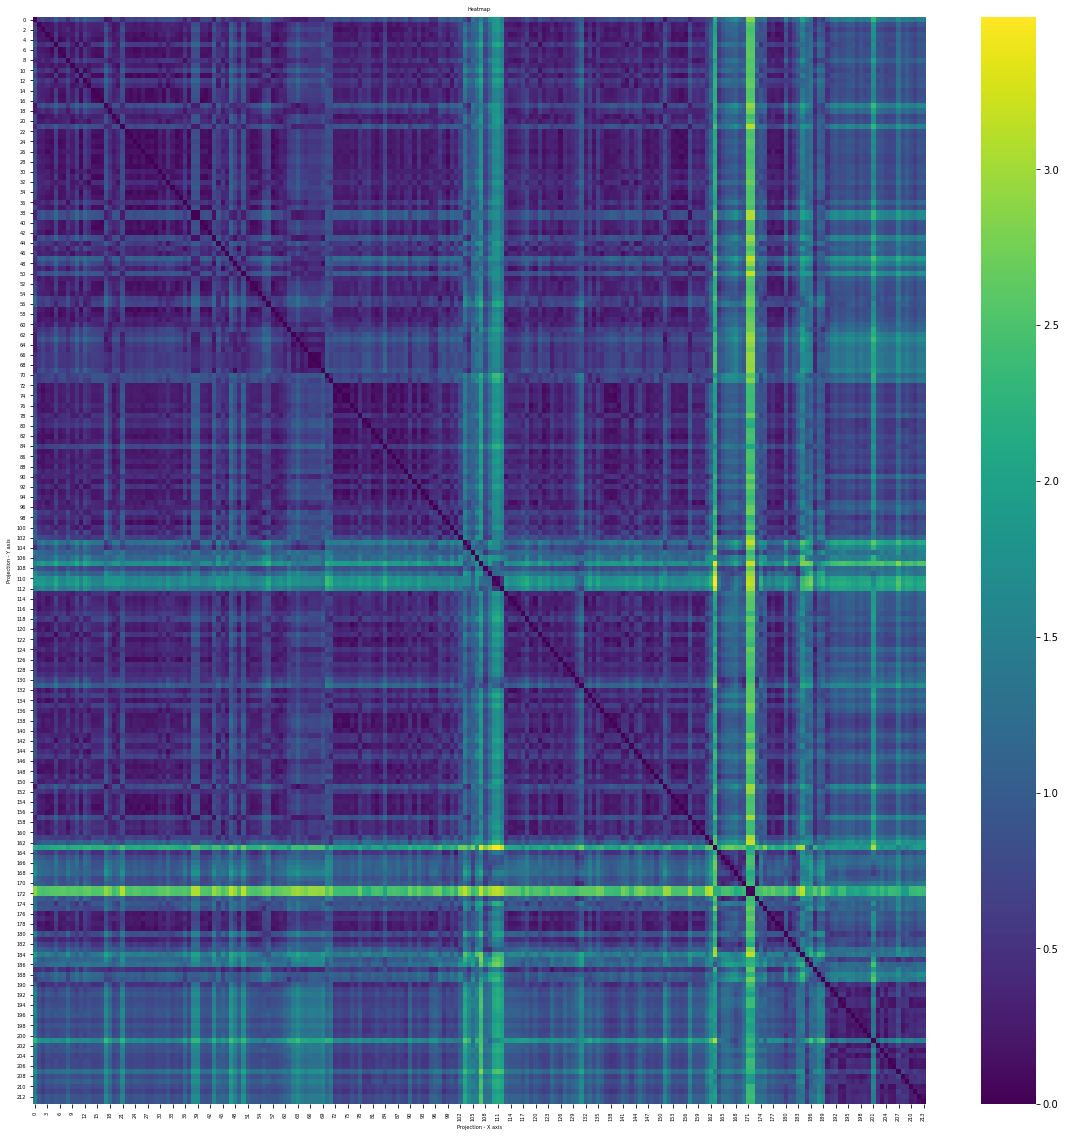

In [8]:
plt.figure(figsize=(20, 20))
sns.heatmap(dist_matrix, cmap='viridis', annot=False, annot_kws={"size": 10})

title_fontsize = 5
label_fontsize = 5

plt.title('Heatmap', fontsize=title_fontsize)
plt.xlabel('Projection - X axis', fontsize=label_fontsize)
plt.ylabel('Projection - Y axis', fontsize=label_fontsize)

ax = plt.gca()
ax.tick_params(axis='x', labelsize=label_fontsize)
ax.tick_params(axis='y', labelsize=label_fontsize)

plt.show()

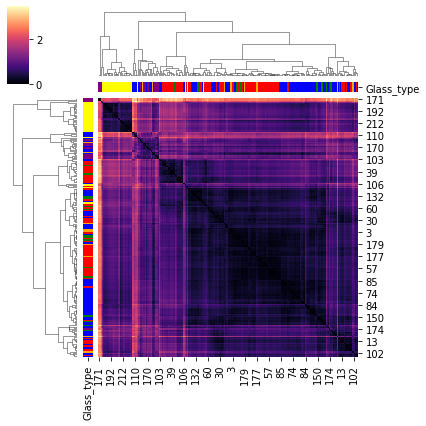

In [9]:
# Create a color mapping based on the species
species_color_mapping = X_proj_fin['Glass_type'].map({1: 'red', 2: 'blue', 3: 'green', 5: 'purple', 6: 'orange', 7: 'yellow'})

# Create a clustermap using the distance matrix and fastcluster with matching colors
linkage_matrix = fastcluster.linkage(condensed_dist_matrix, method='ward')
sns.clustermap(dist_matrix, cmap='magma', figsize=(6, 6), row_linkage=linkage_matrix, col_linkage=linkage_matrix,
               row_colors=species_color_mapping, col_colors=species_color_mapping)

# Show the plot
plt.show()

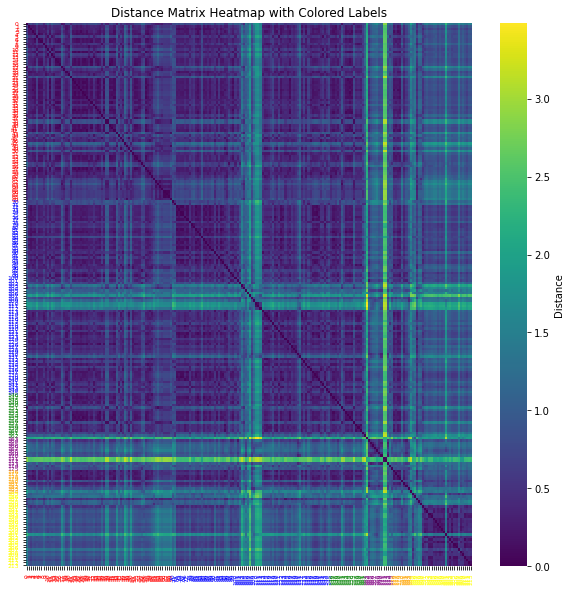

In [10]:
# Create a custom color mapping based on the species
species_color_mapping = X_proj_fin['Glass_type'].map({1: 'red', 2: 'blue', 3: 'green', 5: 'purple', 6: 'orange', 7: 'yellow'})
# Plot the distance matrix heatmap with colored labels
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dist_matrix, cmap='viridis', ax=ax,
            cbar_kws={'label': 'Distance'})

# Set the tick labels and colors
ax.set_xticks(np.arange(dist_matrix.shape[0]) + 0.5)
ax.set_yticks(np.arange(dist_matrix.shape[0]) + 0.5)
ax.set_xticklabels(species_color_mapping.index, rotation=90, fontsize=6)
ax.set_yticklabels(species_color_mapping.index, rotation=0, fontsize=6)

# Color the tick labels
for tick, color in zip(ax.get_xticklabels(), species_color_mapping):
    tick.set_color(color)

for tick, color in zip(ax.get_yticklabels(), species_color_mapping):
    tick.set_color(color)

# Show the plot
plt.title('Distance Matrix Heatmap with Colored Labels')
plt.show()

In [11]:
# Dump to CSV

dist_matrix.to_csv('COMAD-wheat.csv', index=False)

In [12]:
# Find the point you need
point = 177
X_proj_fin.iloc[[point]]['Glass_type']

177    6
Name: Glass_type, dtype: int64

In [13]:
X_proj_fin.iloc[[177]]

,0,1,2,3,4,ID,Glass_type
177,0.893586,0.237725,0.495735,-0.131871,0.386134,178,6


In [14]:
# Load Dataframe for K-nn
knn_df = X_proj_fin

# Select the columns corresponding to the features
features = knn_df[[0, 1, 2, 3, 4]]

# Create a NearestNeighbors object
nbrs = NearestNeighbors(n_neighbors=21, algorithm='ball_tree').fit(features)

# Find the point in the dataset corresponding to point 565
point_in_df = X_proj_fin.iloc[[177]][[0, 1, 2, 3, 4]]

# Find the 10 nearest neighbors
distances, indices = nbrs.kneighbors(point_in_df)

# Print the ids and point numbers of the 10 nearest neighbors
neighbors_df = pd.DataFrame(columns=['ID', 'Glass_type'])
for i in range(1, len(indices[0])):
    neighbor_index = indices[0][i]
    neighbor_point_no = knn_df.index[neighbor_index]
    neighbor_point_diag = knn_df.loc[neighbor_index, 'Glass_type']
    print(f"Neighbor {i},  Point No. = {neighbor_point_no}, Glass Type = {neighbor_point_diag}")
    neighbors_df = neighbors_df.append({ 'Neighbor': i, 'Point No knn': neighbor_point_no, 'Glass_Type': neighbor_point_diag }, ignore_index=True)

# Number of nearest neighbors
k = 20

# Calculate the k-nearest neighbors from the distance matrix
nearest_neighbors = dist_matrix.iloc[200].values.argsort()[1:k+1]

# Create a DataFrame with the indices of the k-nearest neighbors
nearest_neighbors_df = pd.DataFrame(nearest_neighbors, columns=['Point No Dist Matrix'])
column_to_add = nearest_neighbors_df['Point No Dist Matrix']
neighbors_df = neighbors_df.join(column_to_add)

# Dump the dataset as a .csv file
neighbors_df.to_csv('knn_comad_pca.csv', index=False)

Neighbor 1,  Point No. = 40, Glass Type = 1
Neighbor 2,  Point No. = 52, Glass Type = 1
Neighbor 3,  Point No. = 16, Glass Type = 1
Neighbor 4,  Point No. = 53, Glass Type = 1
Neighbor 5,  Point No. = 25, Glass Type = 1
Neighbor 6,  Point No. = 57, Glass Type = 1
Neighbor 7,  Point No. = 7, Glass Type = 1
Neighbor 8,  Point No. = 31, Glass Type = 1
Neighbor 9,  Point No. = 11, Glass Type = 1
Neighbor 10,  Point No. = 41, Glass Type = 1
Neighbor 11,  Point No. = 29, Glass Type = 1
Neighbor 12,  Point No. = 34, Glass Type = 1
Neighbor 13,  Point No. = 24, Glass Type = 1
Neighbor 14,  Point No. = 22, Glass Type = 1
Neighbor 15,  Point No. = 37, Glass Type = 1
Neighbor 16,  Point No. = 15, Glass Type = 1
Neighbor 17,  Point No. = 6, Glass Type = 1
Neighbor 18,  Point No. = 42, Glass Type = 1
Neighbor 19,  Point No. = 176, Glass Type = 6
Neighbor 20,  Point No. = 124, Glass Type = 2
